# Kaiser Window State

## Overview

The Kaiser window state is defined as
$$ |\Psi \rangle := \frac{1}{\sqrt{\sum_x |f(x)|^2}} \sum_{x=0}^{N-1} f(x) |x\rangle, $$
where the amplitude is described by the Kaiser window function $f(x) = \frac{I_0(\beta \sqrt{1-x^2})}{I_0(\beta)}$. Here, $I_0$ is the zeroth modified Bessel function of the first kind. The Kaiser window function can be used in quantum phase estimation to boost the success probability without coherently calculating the median of several phase evaluations.

Just as the preprint [1] proposed the Gaussian state preparation procedure, the authors also proposed a procedure for preparing Kaiser window states. It leverages the same block encoding as before, i.e. $\sum_x \sin(x/N)|x\rangle \langle x|$. The problem can then be reduced to finding phase factors generating the following function:
$$ h(z) = f(\arcsin(z)) \propto I_0 \left( \beta \sqrt{1-\arcsin^2(z)} \right), $$
where $z=\sin(x)$ transforms the domain to $z \in [0,\sin(1)]$.

## Setup and approximate target function

/Users/jameslarsen/miniconda3/envs/qspy/lib/python3.13/site-packages/qsppack/utils.py:282: ComplexWarning: Casting complex values to real discards the imaginary part
  fx[ind_union] = opts['fscale'] * func(xpts[ind_union])


norm error = 1.9280569363289146e-09
max of solution = 0.9799999996847971


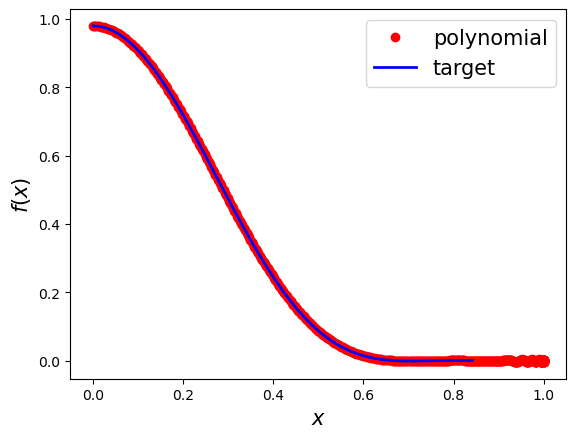

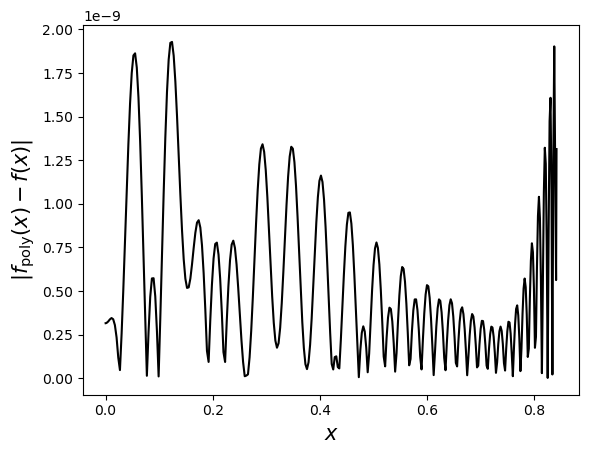

In [1]:
from scipy.special import jv
import numpy as np
from qsppack.utils import cvx_poly_coef

beta = 8
targ = lambda x: jv(0, 1j*beta * np.sqrt(np.complex128(1 - 2*np.arcsin(x)**2))) / jv(0, 1j*beta)
targ = np.vectorize(targ)
deg = 100
parity = deg % 2

opts = {
    'intervals': [0, np.sin(1)],
    'objnorm': np.inf,
    'epsil': 0.01,
    'npts': 500,
    'fscale': 0.98,
    'isplot': True,
    'method': 'cvxpy',
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'targetPre': True
}

coef_full = cvx_poly_coef(targ, deg, opts)
coef = coef_full[parity::2]

## Solving the phase factors and verifying

iter err          
   1  +1.4970e-01
   2  +3.1540e-02
   3  +4.7445e-03
   4  +2.2484e-04
   5  +6.1825e-07
   6  +4.7276e-12
Stop criteria satisfied.
The residual error is
7.993605777301127e-15


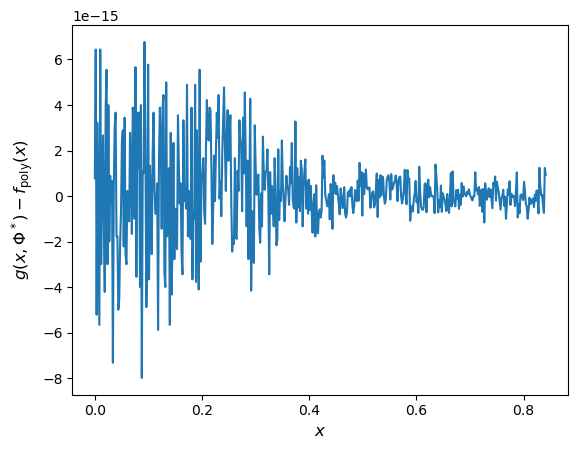

In [2]:
opts['method'] = 'Newton'

from qsppack.solver import solve
phi_proc, out = solve(coef, parity, opts)

from qsppack.utils import chebyshev_to_func, get_entry
import matplotlib.pyplot as plt

xlist = np.linspace(0, np.sin(1), 500)
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. McArdle, S., Gilyén, A., & Berta, M. (2022). Quantum state preparation without coherent arithmetic. *arXiv:2210.14892*.